In [1]:
import tensorflow.keras as keras
from tensorflow.keras import initializers,regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import math
import matplotlib.pylab as plt
import matplotlib
from random import random

In [2]:
import numpy as np
import pandas as pd

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [4]:
def new_df(df,mass):
    df['mass'] = [mass for i in range(len(df))]
    df['log_energy'] = np.log10(df['energy'])
    df['cos_zenith'] = np.cos(df['zenith'])
    df['log_energy_loss'] = np.log10(df['energy_loss'])
    df['log_xo'] = np.log10(df['new_xo'])
    df['log_m_r'] = np.log10(df['m_r'])
    df['log_charge'] = np.log10(df['charge'])
    df['log_s_std'] = np.log10(df['s_std'])
    df['log_s_mean'] = np.log10(df['s_mean'])
    df['log_cube_N'] = np.log(df['N'])**3
    df['log_MaxNum'] = np.log10(df['MaxNum'])
    df = df.loc[(df['Xmax']<900)&
                (df['Xmax']>400)&
                (np.isnan(df['log_charge'])==False)&
                (df['fit_status_m']!=0)&
                (df['S125']>0)&
                (df['m_r']>1e-8)&
                (df['m_r']<2e-4)&
                (abs(df['m_chi2'])<2)&
                (df['ghRedChiSqr']<500)&
                (abs(df['max_check'])<=15)&
               (abs(df['m_125'])<10)&
               (df['m_s']>=0)&
               (df['m_s']<1.5)&
               (df['m_s2']>=0)&
               (df['m_s2']<50)&
               (df['m_o']<5)&
               (df['zenith']<45*(np.pi/180))]
    return df

In [5]:
def binning(x,y,bins,name=None,plot=False):
    check1 = list(zip(x,y))
    hist1 = np.histogram(x,bins=bins)
    mean = [[] for i in range(len(hist1[1][0:len(hist1[1])-1]))]
    mean_count = np.zeros(len(mean))
    index = range(len(mean))
    for i in check1:
        for j in index:
            if (i[0] > hist1[1][j] and i[0] < hist1[1][j+1]):
                mean[j].append( i[1])
                mean_count[j]+=1

    mean_overall = [np.mean(i) for i in mean]
    std_mean = [np.std(i) for i in mean]
    median = [np.median(i) for i in mean]
    
    bins = hist1[1][0:len(hist1[1])-1]
    if plot:
        mean1 = 0
        std1 = 0
        for j in range(len(mean)):
            plot_value = [(i-mean_overall[j]) for i in mean[j]]
            mean1+=abs(np.mean(plot_value))
            std1+=abs(np.std(plot_value))
            plt.hist(plot_value,bins=20,label="mean: %f \n std: %f"%(np.mean(plot_value),np.std(plot_value)))
            plt.xlabel('Residual')
            plt.title(name+'%.2f to %.2f'%(hist1[1][j],hist1[1][j+1]))
            plt.xlim(-100,100)
            plt.legend()
            #plt.savefig(name+'_%.2f.png'%(hist1[1][j]))
            plt.show()
            plt.clf()
        print(mean1/len(mean),std1/len(mean))
    return mean_overall,std_mean,bins,median

In [6]:
iron = pd.read_csv('Iron.csv')
proton = pd.read_csv('Proton.csv')
helium = pd.read_csv('Helium.csv')
oxygen = pd.read_csv('Oxygen.csv')
proton2 = pd.read_csv('Proton2.csv')
iron2 =  pd.read_csv('Iron2.csv')
proton3 = pd.read_csv('Proton3.csv')
iron3 = pd.read_csv('Iron3.csv')
proton4 = pd.read_csv('Proton4.csv')
iron4 = pd.read_csv('Iron4.csv')

In [7]:
iron.keys()

Index(['Unnamed: 0', 'mass', 'energy', 'zenith', 'S125', 'energy_loss',
       'he_stoch', 'he_stoch2', 'Xmax', 'Xo', 'A', 'm_125', 'm_r', 'm_s',
       'm_s2', 'm_o', 'm_chi2', 'fit_status_m', 's_mean', 's_std', 'charge',
       'N', 'ghRedChiSqr', 'firstint', 'max_check', 'new_xmax', 'new_xo',
       'new_lambda', 'fit_status', 'new_chi2', 'difference', 'MaxNum'],
      dtype='object')

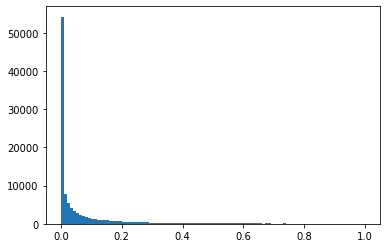

In [8]:
plt.hist(iron['m_chi2'].values[(iron['m_chi2'].values<1)],bins=100)
plt.show()

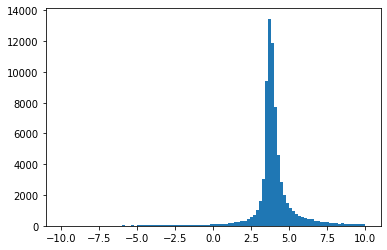

In [9]:
plt.hist(iron['m_125'].values[(iron['m_chi2'].values!=0)&(iron['m_chi2'].values<1)&(abs(iron['m_125'].values)<10)],bins=100)
plt.show()

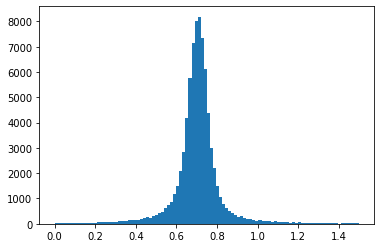

In [10]:
plt.hist(iron['m_s'][(iron['m_s'].values<1.5)&(iron['m_s'].values>0)],bins=100)
plt.show()

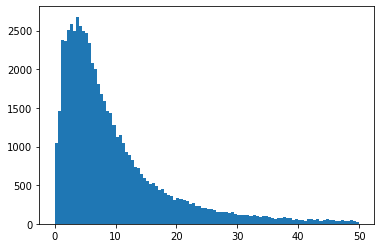

In [11]:
plt.hist(iron['m_s2'][(iron['m_s2'].values<50)&(iron['m_s2'].values>0)],bins=100)
plt.show()

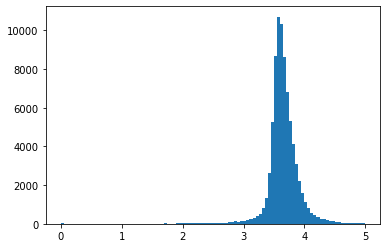

In [12]:
plt.hist(iron['m_o'][(iron['m_o'].values<5)&(iron['m_o'].values>0)],bins=100)
plt.show()

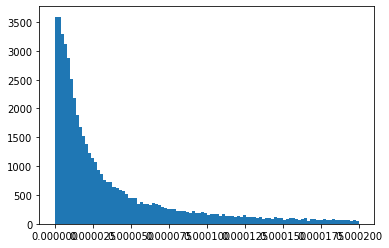

In [13]:
plt.hist(iron['m_r'][(iron['m_r'].values<2e-4)&(iron['m_r'].values>1e-8)],bins=100)
plt.show()

In [14]:
iron = new_df(iron,4)
proton = new_df(proton,1)
helium = new_df(helium,2)
oxygen = new_df(oxygen,3)
proton2 = new_df(proton2,1)
iron2 = new_df(iron2,4)
proton3 = new_df(proton3,1)
iron3 = new_df(iron3,4)
proton4 = new_df(proton4,1)
iron4 = new_df(iron4,4)

/home/andy/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/andy/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/andy/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


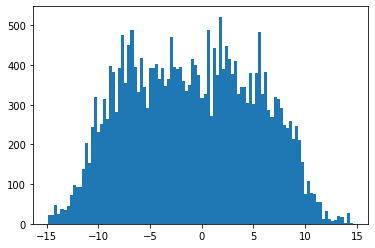

In [15]:
plt.hist(oxygen['max_check'].values,bins=100)
plt.show()

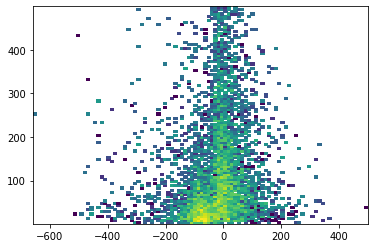

In [16]:
plt.hist2d(proton['Xo'],proton['ghRedChiSqr'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

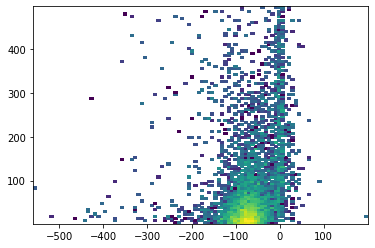

In [17]:
plt.hist2d(iron['Xo'],iron['ghRedChiSqr'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [18]:
from sklearn.cluster import KMeans
import seaborn

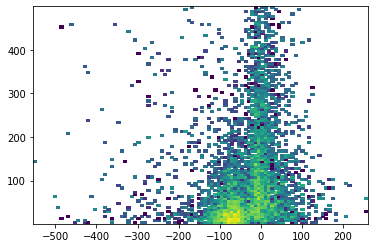

In [19]:
plt.hist2d(helium['Xo'],helium['ghRedChiSqr'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

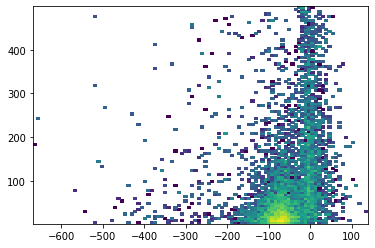

In [20]:
plt.hist2d(oxygen['Xo'],oxygen['ghRedChiSqr'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

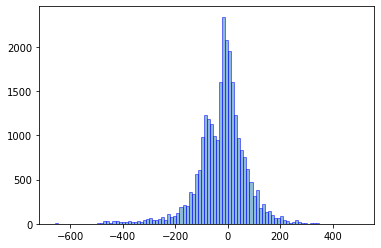

In [21]:
plt.hist(proton['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Proton_Xo.png')

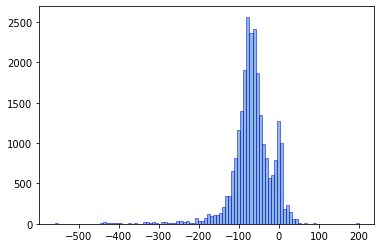

In [22]:
plt.hist(iron['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Iron_Xo.png')

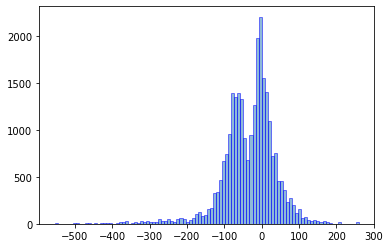

In [23]:
plt.hist(helium['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Helium_Xo.png')

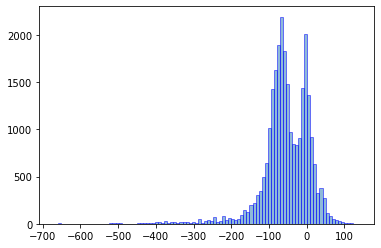

In [24]:
plt.hist(oxygen['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Oxygen_Xo.png')

In [25]:
df = iron.append(proton)
df = df.append(helium)
df = df.append(oxygen)
df = df.append(proton2)
df = df.append(iron2)
df = df.append(proton3)
df = df.append(iron3)
df = df.append(proton4)
df = df.append(iron4)

In [26]:
df.keys()

Index(['Unnamed: 0', 'mass', 'energy', 'zenith', 'S125', 'energy_loss',
       'he_stoch', 'he_stoch2', 'Xmax', 'Xo', 'A', 'm_125', 'm_r', 'm_s',
       'm_s2', 'm_o', 'm_chi2', 'fit_status_m', 's_mean', 's_std', 'charge',
       'N', 'ghRedChiSqr', 'firstint', 'max_check', 'new_xmax', 'new_xo',
       'new_lambda', 'fit_status', 'new_chi2', 'difference', 'MaxNum',
       'log_energy', 'cos_zenith', 'log_energy_loss', 'log_xo', 'log_m_r',
       'log_charge', 'log_s_std', 'log_s_mean', 'log_cube_N', 'log_MaxNum'],
      dtype='object')

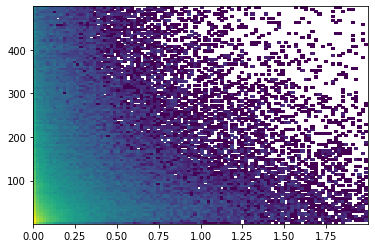

In [27]:
plt.hist2d(df['m_chi2'].values,df['ghRedChiSqr'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

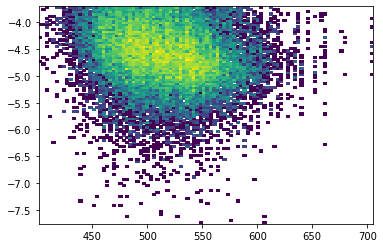

In [28]:
plt.hist2d(iron['Xmax'].values,iron['log_m_r'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

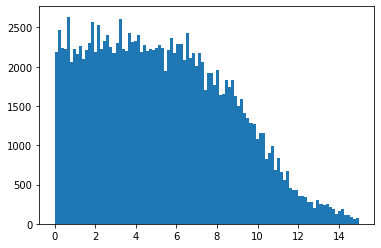

In [29]:
plt.hist(abs(df['max_check']),bins=100)
plt.show()

In [30]:
df['log_energy'] = df['log_energy'].values

In [31]:
df.head()

,Unnamed: 0,mass,energy,zenith,S125,energy_loss,he_stoch,he_stoch2,Xmax,Xo,...,log_energy,cos_zenith,log_energy_loss,log_xo,log_m_r,log_charge,log_s_std,log_s_mean,log_cube_N,log_MaxNum
5,5,4,10826061.0,0.510181,0.840283,NaN,NaN,NaN,477.023376,-70.472221,...,7.034470,0.872656,NaN,0.0,-4.762436,2.512044,-0.985788,-0.147946,66.945326,6.655141
7,7,4,10826061.0,0.500144,0.922709,NaN,NaN,NaN,477.023376,-70.472221,...,7.034470,0.877513,NaN,0.0,-4.316061,2.247012,-0.944173,-0.151576,50.197651,6.655141
15,15,4,15014645.0,0.715913,0.901952,NaN,NaN,NaN,534.116943,-155.566284,...,7.176515,0.754495,NaN,0.0,-4.969042,2.620552,-0.998132,-0.142535,70.298463,6.800355
17,17,4,15014645.0,0.706705,0.776379,NaN,NaN,NaN,534.116943,-155.566284,...,7.176515,0.760505,NaN,0.0,-4.424237,2.325982,-1.148863,-0.168453,58.014582,6.800355
19,19,4,15014645.0,0.715338,0.911911,NaN,NaN,NaN,534.116943,-155.566284,...,7.176515,0.754872,NaN,0.0,-5.077189,2.574436,-1.179882,-0.169488,61.688109,6.800355


In [32]:
check = [math.isnan(i)==0 for i in df['energy_loss'].values]

In [33]:
df_coinc = df[check]

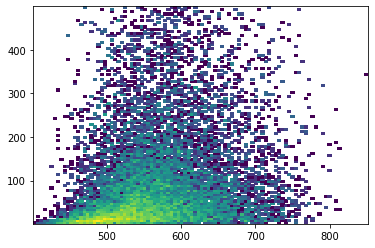

In [34]:
plt.hist2d(df_coinc['Xmax'].values,df_coinc['ghRedChiSqr'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [35]:
iron.corr()[['Xmax','energy','new_xmax','Xo']]

,Xmax,energy,new_xmax,Xo
Unnamed: 0,-0.020463,-0.001352,-0.020392,-0.002988
mass,NaN,NaN,NaN,NaN
energy,0.650536,1.000000,0.458556,-0.056324
zenith,0.098410,0.091707,0.146987,-0.200474
S125,0.725413,0.877556,0.475280,0.012910
energy_loss,0.495347,0.869871,0.363260,-0.101113
he_stoch,0.226410,0.398842,0.174171,-0.003571
he_stoch2,0.094661,0.198623,0.072542,0.014407
Xmax,1.000000,0.650536,0.583598,0.108869
Xo,0.108869,-0.056324,-0.134776,1.000000


In [36]:
check2 = [i==0 for i in np.isnan(df_coinc['log_energy_loss'].values)]
df_coinc = df_coinc.loc[check2]

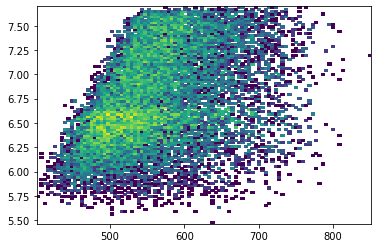

In [37]:
plt.hist2d(df_coinc['Xmax'].values,np.log10(df_coinc['MaxNum'].values),bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [38]:
df_coinc.keys()

Index(['Unnamed: 0', 'mass', 'energy', 'zenith', 'S125', 'energy_loss',
       'he_stoch', 'he_stoch2', 'Xmax', 'Xo', 'A', 'm_125', 'm_r', 'm_s',
       'm_s2', 'm_o', 'm_chi2', 'fit_status_m', 's_mean', 's_std', 'charge',
       'N', 'ghRedChiSqr', 'firstint', 'max_check', 'new_xmax', 'new_xo',
       'new_lambda', 'fit_status', 'new_chi2', 'difference', 'MaxNum',
       'log_energy', 'cos_zenith', 'log_energy_loss', 'log_xo', 'log_m_r',
       'log_charge', 'log_s_std', 'log_s_mean', 'log_cube_N', 'log_MaxNum'],
      dtype='object')

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
validation = df_coinc.sample(frac=0.1,random_state=42)

In [41]:
'm_r','m_s','m_125','m_o','m_s2'

('m_r', 'm_s', 'm_125', 'm_o', 'm_s2')

In [42]:
validation_y =  validation[['Xo','log_energy','Xmax','Xo','mass']].values
validation_X = validation[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_125','m_o','m_s2','m_s']].values

In [43]:
df_coinc = df_coinc.drop(validation.index)

In [44]:
y = df_coinc[['Xo','log_energy','Xmax','Xo','mass']].values
X = df_coinc[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_125','m_o','m_s2','m_s']].values
#X = df_coinc[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2']].values

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
weight = []
for i in y_train:
    if i[0] == 1:
        weight.append(1)
    elif i[0] == 2:
        weight.append(len(proton)/len(helium))
    elif i[0] == 3:
        weight.append(len(proton)/len(oxygen))
    else:
        weight.append(len(proton)/len(iron))
weight=np.array(weight)

In [47]:
model_best = 'model_coinc_best.h5'

best_model = keras.callbacks.ModelCheckpoint(model_best,
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto')

es = EarlyStopping(monitor='val_loss',patience=10)

input_layer = Input(shape=(len(X[0]),))

model1 = Dense(12,activation='relu',bias_regularizer=keras.regularizers.l1(1e-1))(input_layer)

model2 = Dense(7,activation='relu')(model1)

model3 = Concatenate(axis=-1,activity_regularizer=keras.regularizers.l2(1e-5))([input_layer,model1,model2])

model3 = Dropout(0.5)(model3)

model3 = BatchNormalization(renorm=True)(model3)

prediction1 = Dense(4,activation='linear',kernel_regularizer = keras.regularizers.l2(1e-5))(model3)

model = Model(inputs=input_layer,outputs=prediction1)

opt = keras.optimizers.Adam(decay=1e-5)

model.compile(optimizer=opt , loss = 'mse')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [48]:
history = model.fit(X_train,y_train[:,1:5],
                    epochs=200,
                    shuffle=True,
                    validation_data = (X_test,y_test[:,1:5]),
                    callbacks=[best_model,es],
                   sample_weight=weight)

Train on 22545 samples, validate on 5637 samples
Epoch 1/200
22545/22545 [==============================] - 2s 73us/sample - loss: 82806.1011 - val_loss: 74837.6754
Epoch 2/200
22545/22545 [==============================] - 1s 44us/sample - loss: 68276.8395 - val_loss: 54020.3555
Epoch 3/200
22545/22545 [==============================] - 1s 46us/sample - loss: 44241.4411 - val_loss: 30391.0135
Epoch 4/200
22545/22545 [==============================] - 1s 35us/sample - loss: 22041.9132 - val_loss: 12641.7093
Epoch 5/200
22545/22545 [==============================] - 1s 34us/sample - loss: 8266.1660 - val_loss: 4303.4450
Epoch 6/200
22545/22545 [==============================] - 1s 44us/sample - loss: 2960.4522 - val_loss: 2036.3753
Epoch 7/200
22545/22545 [==============================] - 1s 35us/sample - loss: 1841.1201 - val_loss: 1589.1768
Epoch 8/200
22545/22545 [==============================] - 1s 34us/sample - loss: 1748.4019 - val_loss: 1543.9793
Epoch 9/200
22545/22545 [======

In [49]:
best_model = load_model('model_coinc_best.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


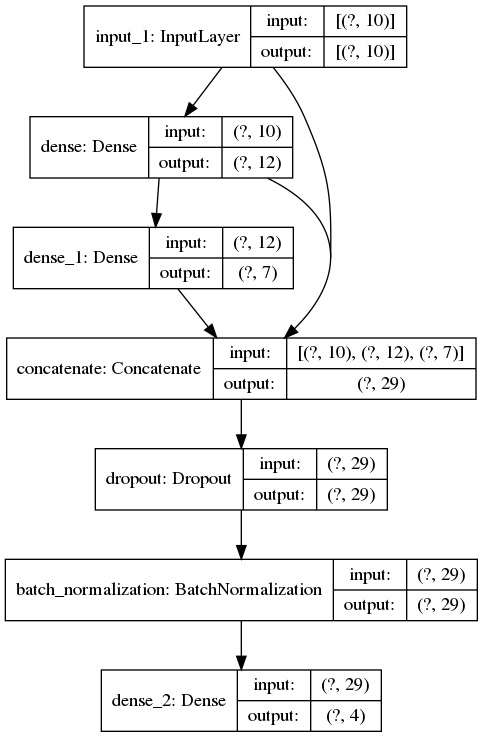

In [53]:
from tensorflow.keras.utils import plot_model
plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [54]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [55]:
tree =BaggingRegressor(DecisionTreeRegressor(splitter='best',max_features='log2',random_state=42),n_estimators=400,bootstrap=True,random_state=42)

In [56]:
tree.fit(X_train[:,0:9],y_train[:,1])

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='log2',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=42,
                                                      splitter='best'),
                 bootstrap=T

In [57]:
predictions = best_model.predict(X_test)

In [58]:
predictions2 = tree.predict(X_test[:,0:9])

In [59]:
energy_predictions = predictions2
energy = np.array(list(zip(*y_test))[1])
xmax = np.array(list(zip(*y_test))[2])
#x_o = np.array(list(zip(*y_test))[0])
xmax_predictions = np.array(list(zip(*predictions))[1])
mass = np.array(list(zip(*y_test))[4])

In [60]:
from scipy.optimize import curve_fit
def line_function(x,m,b):
    return m * x + b
def quadratic_function(x,m,b):
    y = b + m * x
    return y

In [61]:
value = [(i-j) for i,j in zip(xmax_predictions,xmax)]

In [62]:
validation_xmax = np.array(list(zip(*validation_y)))[2]
X_test_new = [np.hstack([i,j]) for i,j in zip(X_test,xmax_predictions)]
validation_X_new = [np.hstack([i,j]) for i,j in zip(validation_X,validation_xmax)]

In [63]:
check_predictions = best_model.predict(validation_X)
check_predictions2 = tree.predict(validation_X[:,0:9])

In [64]:
from sklearn.linear_model import LinearRegression

In [65]:
line_model = LinearRegression()

In [66]:
line_model.fit(xmax_predictions.reshape(-1,1),value)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
bias = line_model.predict(xmax_predictions.reshape(-1,1))
bias2 = line_model.predict(validation_xmax.reshape(-1,1))

In [68]:
xmax_predictions = np.array([(i-j) for i,j in zip(xmax_predictions,bias)])
xmax_predictions2 = np.array([(i-j) for i,j in zip(list(zip(*check_predictions))[1],bias2)])

In [69]:
#xmax_predictions2 = list(zip(*check_predictions))[1]

In [70]:
import matplotlib

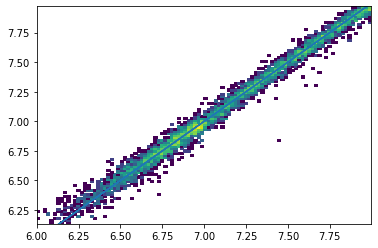

In [71]:
plt.hist2d(energy,energy_predictions,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(energy,energy)
plt.show()

In [72]:
np.corrcoef(energy,energy_predictions)[0][1]

0.9938623676902839

In [73]:
print(np.mean([(i-j)**2 for i,j in zip(energy,energy_predictions)]))

0.002612454195473095


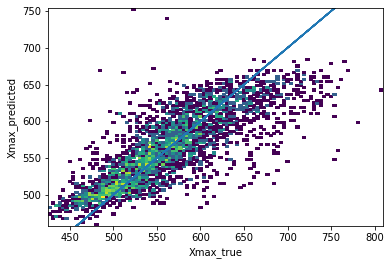

In [74]:
plt.hist2d(validation_xmax,xmax_predictions2,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(validation_xmax,validation_xmax)
plt.xlabel('Xmax_true')
plt.ylabel('Xmax_predicted')
plt.savefig('True_vs_predicted_after.png')
plt.show()

In [75]:
mean_xmax,std_xmax,bins_xmax,median_xmax = binning(xmax,xmax_predictions,15,plot=False)

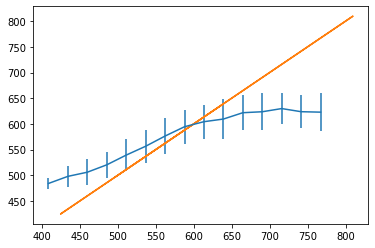

In [76]:
plt.errorbar(bins_xmax,mean_xmax,yerr=std_xmax)
plt.plot(validation_xmax,validation_xmax)
plt.savefig('before.png')

In [77]:
mse = np.mean([(i-j)**2 for i,j in zip(xmax,xmax_predictions)])
print(mse)

1857.7195906552856


In [78]:
np.corrcoef(validation_xmax,xmax_predictions2)[0][1]

0.8042475449680118

In [79]:
check = (energy_predictions>=0)

In [80]:
predictions = predictions[check]

In [81]:
mass = mass[check]

In [82]:
energy = np.array(energy)

In [83]:
iron_energy = predictions2[mass==4]
proton_energy = predictions2[mass==1]
helium_energy = predictions2[mass==2]
oxygen_energy= predictions2[mass==3]

In [84]:
iron_xmax = np.array(xmax_predictions)[mass==4]
proton_xmax = np.array(xmax_predictions)[mass==1]
helium_xmax = np.array(xmax_predictions)[mass==2]
oxygen_xmax = np.array(xmax_predictions)[mass==3]

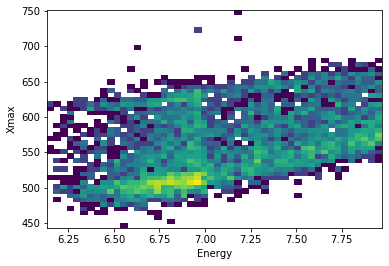

In [85]:
Xmax_predicted = xmax_predictions
check = (Xmax_predicted>400)&(Xmax_predicted<800)
plt.hist2d(predictions2[check],Xmax_predicted[check],bins=50,norm=matplotlib.colors.LogNorm())
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

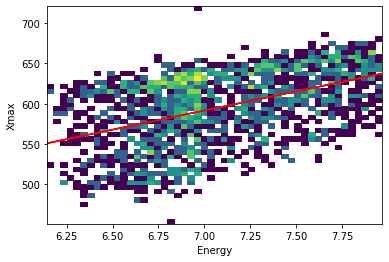

47.44677033423234 259.37538375900675


In [86]:
Xmax_predicted = proton_xmax
check_proton = (Xmax_predicted>400)&(Xmax_predicted<800)
fit_proton = curve_fit(line_function,proton_energy[check_proton],Xmax_predicted[check_proton])
output_xmax_proton = line_function(proton_energy[check_proton],fit_proton[0][0],fit_proton[0][1])

plt.hist2d(proton_energy[check_proton],Xmax_predicted[check_proton],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(proton_energy[check_proton],output_xmax_proton,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit_proton[0][0],fit_proton[0][1])

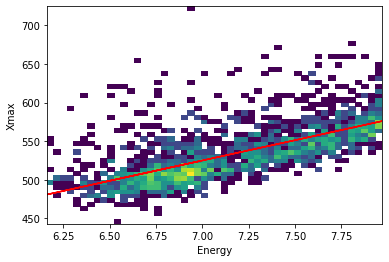

52.5903610672904 156.88389813974015


In [87]:
Xmax_predicted = iron_xmax
check_iron = (Xmax_predicted>400)&(Xmax_predicted<800)
fit_iron = curve_fit(line_function,iron_energy[check_iron],Xmax_predicted[check_iron])
output_xmax_iron = line_function(iron_energy[check_iron],fit_iron[0][0],fit_iron[0][1])

plt.hist2d(iron_energy[check_iron],Xmax_predicted[check_iron],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(iron_energy[check_iron],output_xmax_iron,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit_iron[0][0],fit_iron[0][1])

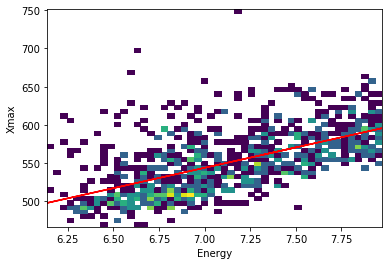

53.29800402062212 170.639444220374


In [88]:
Xmax_predicted = oxygen_xmax
check = (Xmax_predicted>400)&(Xmax_predicted<800)
fit = curve_fit(line_function,oxygen_energy[check],Xmax_predicted[check])
output_xmax = line_function(oxygen_energy[check],fit[0][0],fit[0][1])

plt.hist2d(oxygen_energy[check],Xmax_predicted[check],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(oxygen_energy[check],output_xmax,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit[0][0],fit[0][1])

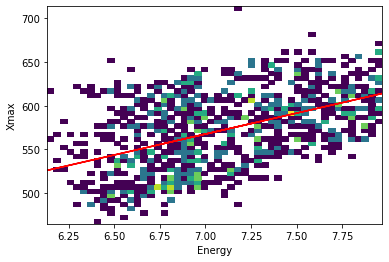

47.961276917078415 231.93785999701333


In [89]:
Xmax_predicted = helium_xmax
check = (Xmax_predicted>400)&(Xmax_predicted<800)
fit = curve_fit(line_function,helium_energy[check],Xmax_predicted[check])
output_xmax = line_function(helium_energy[check],fit[0][0],fit[0][1])

plt.hist2d(helium_energy[check],Xmax_predicted[check],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(helium_energy[check],output_xmax,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit[0][0],fit[0][1])

In [90]:
plot = False
bins = 30
mean_proton,std_proton,bins_proton,median_proton = binning(proton_energy,proton_xmax,bins,name='proton',plot=plot)
mean_iron,std_iron,bins_iron,median_iron = binning(iron_energy,iron_xmax,bins,name='iron',plot=plot)
mean_oxygen,std_oxygen,bins_oxygen,median_oxygen = binning(oxygen_energy,oxygen_xmax,bins,name='oxygen',plot=plot)
mean_helium,std_helium,bins_helium,median_helium = binning(helium_energy,helium_xmax,bins,name='helium',plot=plot)

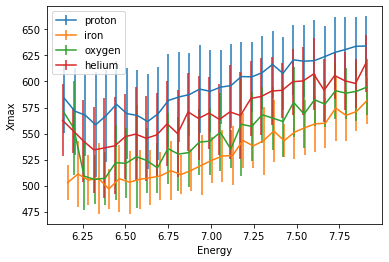

In [91]:
plt.errorbar(bins_proton,mean_proton,yerr=std_proton,label='proton')
plt.errorbar(bins_iron,mean_iron,yerr=std_iron,label='iron')
plt.errorbar(bins_oxygen,mean_oxygen,yerr=std_oxygen,label='oxygen')
plt.errorbar(bins_helium,mean_helium,yerr=std_helium,label='helium')
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Xmax')
plt.savefig('All_species_energy_xmax3.png')
#plt.show()

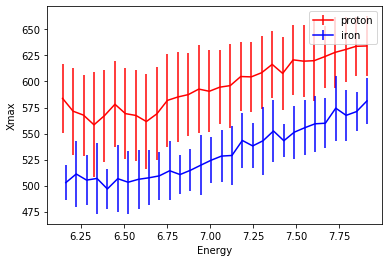

In [92]:
plt.errorbar(bins_proton,mean_proton,yerr=std_proton,color='r',label='proton')
plt.errorbar(bins_iron,mean_iron,yerr=std_iron,color='b',label='iron')
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Xmax')
plt.savefig('Proton_vs_Iron.png')
#plt.show()